# Homework 3 - Uncovering World Events using Twitter Hashtags

## ... and learning about Spark `DataFrames` along the way

In this notebook, we will use temporal information about Twitter hashtags to discover trending topics and potentially uncover world events as they occurred. 

__Hand-in:__

- __Due: 28.04.2020 23:59:59 CET__
- `git push` your final verion to your group's Renku repository before the due
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your codes readable

### Hashtags

The idea here is that when an event is happening and people are having a conversation about it on Twitter, a set of uniform hashtags that represent the event spontaneously evolves. Twitter users then use those hashtags to communicate with one another. Some hashtags, like `#RT` for "retweet" or just `#retweet` are used frequently and don't tell us much about what is going on. But a sudden appearance of a hashtag like `#oscars` probably indicates that the oscars are underway. For a particularly cool example of this type of analysis, check out [this blog post about earthquake detection using Twitter data](https://blog.twitter.com/official/en_us/a/2015/usgs-twitter-data-earthquake-detection.html) (although they search the text and not necessarily hashtags).

In [1]:
%%local
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 18
plt.style.use('fivethirtyeight')

## Initialize the `SparkSession`

In [2]:
spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3734,application_1587988164357_0350,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3728,application_1587988164357_0344,pyspark,idle,Link,Link,
3733,application_1587988164357_0349,pyspark,idle,Link,Link,
3734,application_1587988164357_0350,pyspark,idle,Link,Link,✔


In [4]:
%%help

Magic,Example,Explanation
info,%%info,Outputs session information for the current Livy endpoint.
cleanup,%%cleanup -f,"Deletes all sessions for the current Livy endpoint, including this notebook's session. The force flag is mandatory."
delete,%%delete -f -s 0,Deletes a session by number for the current Livy endpoint. Cannot delete this kernel's session.
logs,%%logs,Outputs the current session's Livy logs.
configure,"%%configure -f{""executorMemory"": ""1000M"", ""executorCores"": 4}",Configure the session creation parameters. The force flag is mandatory if a session has already been created and the session will be dropped and recreated.Look at Livy's POST /sessions Request Body for a list of valid parameters. Parameters must be passed in as a JSON string.
spark,%%spark -o dfdf = spark.read.parquet('...,"Executes spark commands. Parameters: -o VAR_NAME: The Spark dataframe of name VAR_NAME will be available in the %%local Python context as a Pandas dataframe with the same name. -m METHOD: Sample method, either take or sample. -n MAXROWS: The maximum number of rows of a dataframe that will be pulled from Livy to Jupyter. If this number is negative, then the number of rows will be unlimited. -r FRACTION: Fraction used for sampling."
sql,%%sql -o tables -qSHOW TABLES,"Executes a SQL query against the variable sqlContext (Spark v1.x) or spark (Spark v2.x). Parameters: -o VAR_NAME: The result of the SQL query will be available in the %%local Python context as a Pandas dataframe. -q: The magic will return None instead of the dataframe (no visualization). -m, -n, -r are the same as the %%spark parameters above."
local,%%locala = 1,All the code in subsequent lines will be executed locally. Code must be valid Python code.
send_to_spark,%%send_to_spark -o variable -t str -n var,"Sends a variable from local output to spark cluster. Parameters: -i VAR_NAME: Local Pandas DataFrame(or String) of name VAR_NAME will be available in the %%spark context as a Spark dataframe(or String) with the same name. -t TYPE: Specifies the type of variable passed as -i. Available options are: `str` for string and `df` for Pandas DataFrame. Optional, defaults to `str`. -n NAME: Custom name of variable passed as -i. Optional, defaults to -i variable name. -m MAXROWS: Maximum amount of Pandas rows that will be sent to Spark. Defaults to 2500."


## PART I: Set up the hashtag `DataFrame` (10 points / 60)

We have prepared the hashtag data spanning the time from May to July, 2016. This is a significant time in modern European history, e.g. see [Brexit](https://en.wikipedia.org/wiki/Brexit). Lets see if we can see any interesting trends about these events in the Twitter data. 

In [5]:
import pyspark.sql.functions as functions

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### I.a: TODO (1 point/10)

Load the **parquet** data from `/data/twitter/parquet/hashtags` into a Spark dataframe using the appropriate `SparkSession` method. 

Look at the first few rows of the dataset - note the timestamp and its units!

In [6]:
# TODO
df = spark.read.parquet("/data/twitter/parquet/hashtags")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- timestamp_s: long (nullable = true)
 |-- id: long (nullable = true)
 |-- lang: string (nullable = true)
 |-- hashtag: string (nullable = true)

In [8]:
df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------------+----+-----------------+
|timestamp_s|                id|lang|          hashtag|
+-----------+------------------+----+-----------------+
| 1464768480|737918607980670976|  tr|          lovebts|
| 1464768480|737918607980670976|  tr|            방탄소년단|
| 1464768480|737918607963873281|  ja|          tokyofm|
| 1464768480|737918607976452096|  en|          SotoBot|
| 1464768480|737918607976497152|  en|           Fenton|
| 1464768480|737918607976497152|  en|     vintageglass|
| 1464768480|737918607976497152|  en|        glassbell|
| 1464768480|737918607959719941|  en|          vintage|
| 1464768480|737918607959719941|  en|            1970s|
| 1464768480|737918607959719941|  en|              mod|
| 1464768481|737918612158189568|  ar|        ابن_الغيم|
| 1464768481|737918612158156802|  en|creativitybooster|
| 1464768481|737918612158156802|  en|    growthhacking|
| 1464768481|737918612158156802|  en| entrepreneurship|
| 1464768481|737918612158222336|  en|    jewelry

### User-defined functions

A neat trick of spark dataframes is that you can essentially use something very much like an RDD `map` method but without switching to the RDD. If you are familiar with database languages, this works very much like e.g. a user-defined function in SQL. 

So, for example, if we wanted to make a user-defined python function that returns the hashtags in lowercase, we could do something like this:

In [9]:
@functions.udf
def lowercase(text):
    """Convert text to lowercase"""
    return text.lower()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The @functions.udf is a "decorator" -- this is really handy python syntactic sugar and in this case is equivalent to:

```python
def lowercase(text):
    return text.lower()
    
lowercase = functions.udf(lowercase)
```

It basically takes our function and adds to its functionality. In this case, it registers our function as a pyspark dataframe user-defined function (UDF).

Using these UDFs is very straightforward and analogous to other Spark dataframe operations. For example:

In [10]:
df.select(lowercase(df.hashtag)).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+
|lowercase(hashtag)|
+------------------+
|           lovebts|
|             방탄소년단|
|           tokyofm|
|           sotobot|
|            fenton|
|      vintageglass|
|         glassbell|
|           vintage|
|             1970s|
|               mod|
|         ابن_الغيم|
| creativitybooster|
|     growthhacking|
|  entrepreneurship|
|     jewelryonetsy|
|           jetteam|
|        teenchoice|
|  choicemalehottie|
|        nowplaying|
|              maui|
+------------------+
only showing top 20 rows

Using a framework like Spark is all about understanding the ins and outs of how it functions and knowing what it offers. One of the cool things about the dataframe API is that many functions are already defined for you (turning strings into lowercase being one of them). 

### I.b: TODO (2 points / 10)

Find the [Spark python API documentation](https://spark.apache.org/docs/latest/api/python/index.html). Look for the `sql` section and find the listing of `sql.functions`. Repeat the above (turning hashtags into lowercase) but use the built-in function.

In [11]:
df.select(functions.lower(df.hashtag)).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+
|   lower(hashtag)|
+-----------------+
|          lovebts|
|            방탄소년단|
|          tokyofm|
|          sotobot|
|           fenton|
|     vintageglass|
|        glassbell|
|          vintage|
|            1970s|
|              mod|
|        ابن_الغيم|
|creativitybooster|
|    growthhacking|
| entrepreneurship|
|    jewelryonetsy|
|          jetteam|
|       teenchoice|
| choicemalehottie|
|       nowplaying|
|             maui|
+-----------------+
only showing top 20 rows

We'll work with a combination of these built-in functions and user-defined functions for the remainder of this homework. 

### I.c: TODO (3 points/10)

Create `english_df` consisting of **lowercase** hashtags from only english-language tweets. In addition, convert the timestamp to a more readable format like this and name the column `date`:

```
2016-05-01 08:30:00
```

Your `english_df` should look something like this:

```
+-----------+----+------------+-------------------+
|timestamp_s|lang|     hashtag|               date|
+-----------+----+------------+-------------------+
| 1464768480|  en|     sotobot|2016-06-01 10:08:00|
| 1464768480|  en|      fenton|2016-06-01 10:08:00|
| 1464768480|  en|vintageglass|2016-06-01 10:08:00|
| 1464768480|  en|   glassbell|2016-06-01 10:08:00|
| 1464768480|  en|     vintage|2016-06-01 10:08:00|
+-----------+----+------------+-------------------+
```

In [12]:
english_df = df.select(df.timestamp_s, df.lang, functions.lower(df.hashtag).alias('hashtag'), 
                       functions.to_timestamp(df.timestamp_s).alias('date')).where(df.lang == 'en')
english_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----+------------------+-------------------+
|timestamp_s|lang|           hashtag|               date|
+-----------+----+------------------+-------------------+
| 1464768480|  en|           sotobot|2016-06-01 10:08:00|
| 1464768480|  en|            fenton|2016-06-01 10:08:00|
| 1464768480|  en|      vintageglass|2016-06-01 10:08:00|
| 1464768480|  en|         glassbell|2016-06-01 10:08:00|
| 1464768480|  en|           vintage|2016-06-01 10:08:00|
| 1464768480|  en|             1970s|2016-06-01 10:08:00|
| 1464768480|  en|               mod|2016-06-01 10:08:00|
| 1464768481|  en| creativitybooster|2016-06-01 10:08:01|
| 1464768481|  en|     growthhacking|2016-06-01 10:08:01|
| 1464768481|  en|  entrepreneurship|2016-06-01 10:08:01|
| 1464768481|  en|     jewelryonetsy|2016-06-01 10:08:01|
| 1464768481|  en|           jetteam|2016-06-01 10:08:01|
| 1464768481|  en|        teenchoice|2016-06-01 10:08:01|
| 1464768481|  en|  choicemalehottie|2016-06-01 10:08:01|
| 1464768481| 

### I.d: TODO (4 points/10)

We "claim" the data contains all twitters from May to July 2017, however, that's not true. Check which (date, hour) are in `english_df` and which are missing, e.g. 2016-05-01, 10h is in the dataframe while 2016-04-01, 10h not.

The (date, hour) tuples that are present in the dataset:

In [13]:
# lit: takes the argument literally. E.g. for concatenating strings
# Ordering of hours is as follows: 0, 1, 10, 11, ..., 19, 2, 20, 21, 22, 23, 3, 4, 5, ..., 9 (which makes perfect sense)
# I guess there is a typo - the year has to be 2016 instead of 2017. I couldn't find any results for the year 2017.
tmp = \
english_df.select(english_df.date, functions.concat(functions.to_date(english_df.date), 
                                   functions.lit(', '), 
                                   functions.hour(english_df.date)).alias('(date, hour)')) \
    .where(english_df.date.between('2016-05-01', '2016-07-31')).drop('date').distinct().orderBy('(date, hour)')
tmp.show(50)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+
|  (date, hour)|
+--------------+
|2016-05-01, 10|
|2016-05-01, 11|
|2016-05-01, 12|
|2016-05-01, 13|
|2016-05-01, 14|
|2016-05-01, 15|
|2016-05-01, 16|
|2016-05-01, 17|
|2016-05-01, 18|
|2016-05-01, 19|
|2016-05-01, 20|
|2016-05-01, 21|
|2016-05-01, 22|
|2016-05-01, 23|
| 2016-05-01, 8|
| 2016-05-01, 9|
| 2016-05-02, 0|
|2016-05-02, 15|
|2016-05-02, 16|
|2016-05-02, 17|
|2016-05-02, 18|
|2016-05-02, 19|
|2016-05-02, 20|
|2016-05-02, 21|
|2016-05-02, 22|
|2016-05-02, 23|
| 2016-05-02, 5|
| 2016-05-02, 6|
| 2016-05-02, 7|
| 2016-05-03, 0|
| 2016-05-03, 1|
|2016-05-03, 10|
|2016-05-03, 11|
|2016-05-03, 12|
|2016-05-03, 13|
|2016-05-03, 14|
|2016-05-03, 15|
|2016-05-03, 16|
|2016-05-03, 17|
|2016-05-03, 18|
|2016-05-03, 19|
| 2016-05-03, 2|
|2016-05-03, 20|
|2016-05-03, 21|
|2016-05-03, 22|
|2016-05-03, 23|
| 2016-05-03, 3|
| 2016-05-03, 4|
| 2016-05-03, 5|
| 2016-05-03, 6|
+--------------+
only showing top 50 rows

In [14]:
import pandas as pd
import numpy as np
tweetdates = tmp.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
dic = {}
datehour = '(date, hour)'
arr = []
datetimerange = pd.date_range(start='2016-05-01', end='2016-07-31').date
for i in datetimerange:
    for hour in range(24):
        arr.append(str(i) + ', ' + str(hour))
dic[datehour] = arr
containsall = pd.DataFrame(dic)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
mydict = {}
nonexistent = []
for i in tweetdates.values[:,0]:
    mydict[i] = True
for i in containsall.values[:,0]:
    if i in mydict:
        pass
    else:
        nonexistent.append(i)
        mydict[i] = True

print('(day, hour) pairs that are not present in the dataset: \n')
for i in nonexistent:
    print(i)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(day, hour) pairs that are not present in the dataset: 

2016-05-01, 0
2016-05-01, 1
2016-05-01, 2
2016-05-01, 3
2016-05-01, 4
2016-05-01, 5
2016-05-01, 6
2016-05-01, 7
2016-05-02, 1
2016-05-02, 2
2016-05-02, 3
2016-05-02, 4
2016-05-02, 8
2016-05-02, 9
2016-05-02, 10
2016-05-02, 11
2016-05-02, 12
2016-05-02, 13
2016-05-02, 14
2016-05-27, 8
2016-05-27, 9
2016-05-27, 10
2016-05-27, 11
2016-05-27, 12
2016-05-27, 13
2016-05-27, 14
2016-05-27, 15
2016-06-02, 8
2016-06-02, 9
2016-06-02, 10
2016-06-02, 11
2016-06-02, 12
2016-06-02, 13
2016-06-02, 14
2016-06-02, 15
2016-06-02, 16
2016-06-02, 17
2016-06-02, 18
2016-06-02, 19
2016-06-02, 20
2016-06-02, 21
2016-06-02, 22
2016-06-02, 23
2016-06-03, 0
2016-06-03, 1
2016-06-03, 2
2016-06-03, 3
2016-06-03, 4
2016-06-03, 5
2016-06-03, 6
2016-06-03, 7
2016-06-03, 8
2016-06-03, 9
2016-06-03, 10
2016-06-03, 11
2016-06-03, 12
2016-06-03, 13
2016-06-03, 14
2016-06-03, 15
2016-06-03, 16
2016-06-03, 17
2016-06-03, 18
2016-06-03, 19
2016-06-03, 20
2016-06-03,

## PART II: Twitter hashtag trends (50 points / 60)

In this section we will try to do a slightly more complicated analysis of the tweets. Our goal is to get an idea of tweet frequency as a function of time for certain hashtags. 

Lets build this up in steps. First, lets see how we can start to organize the tweets by their timestamps. 

As a first easy example, lets say we just want to count the number of tweets per minute over the entire span of our data. For this, we first need a "global" minute value, e.g. "minute of the year" or something similar. 

Spark provides us with some handy built-in dataframe functions that are made for transforming date and time fields. 

Have a look [here](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions) to see the whole list of custom dataframe functions - you will need to use them to complete the next set of TODO items.

Note that the functions can be combined. Consider the following dataframe and its transformation:

In [17]:
from pyspark.sql import Row

# create a sample dataframe with one column "degrees" going from 0 to 180
test_df = spark.createDataFrame(spark.sparkContext.range(180).map(lambda x: Row(degrees=x)), ['degrees'])

# define a function "sin_rad" that first converts degrees to radians and then takes the sine using built-in functions
sin_rad = functions.sin(functions.radians(test_df.degrees))

# show the result
test_df.select(sin_rad).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------+
|SIN(RADIANS(degrees))|
+---------------------+
|                  0.0|
|  0.01745240643728351|
|  0.03489949670250097|
|  0.05233595624294383|
|   0.0697564737441253|
|  0.08715574274765817|
|  0.10452846326765346|
|  0.12186934340514748|
|  0.13917310096006544|
|  0.15643446504023087|
|  0.17364817766693033|
|   0.1908089953765448|
|  0.20791169081775931|
|  0.22495105434386498|
|  0.24192189559966773|
|  0.25881904510252074|
|  0.27563735581699916|
|   0.2923717047227367|
|   0.3090169943749474|
|   0.3255681544571567|
+---------------------+
only showing top 20 rows

### DataFrames `groupBy`

We used `groupBy` already in the previous notebook, but here we will take more advantage of its features. 

One important thing to note is that unlike other RDD or DataFrame transformations, the `groupBy` does not return another DataFrame, but a `GroupedData` object instead, with its own methods. These methods allow you to do various transformations and aggregations on the data of the grouped rows. 

Conceptually the procedure is a lot like this:

![groupby](https://i.stack.imgur.com/sgCn1.jpg)

The column that is used for the `groupBy` is the `key` - once we have the values of a particular key all together, we can use various aggregation functions on them to generate a transformed dataset. In this example, the aggregation function is a simple `sum`. In the simple procedure below, the `key` will be the hashtag.

### II.a: TODO (1 point / 50)

Calculate the top five most common hashtags in the whole english-language dataset.

This should be your result:

```
+-------------+------+
|      hashtag| count|
+-------------+------+
|   mtvhottest|800527|
|veranomtv2016|539028|
|   teenchoice|345208|
|   nowplaying|178561|
|  gameinsight|165237|
+-------------+------+
```

In [18]:
english_df.groupBy('hashtag').count().orderBy('count', ascending=False).show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+------+
|      hashtag| count|
+-------------+------+
|   mtvhottest|800527|
|veranomtv2016|539028|
|   teenchoice|345208|
|   nowplaying|178561|
|  gameinsight|165237|
+-------------+------+
only showing top 5 rows

## Daily hashtag trends

Now we will start to complicate the analysis a bit. Remember, our goal is to uncover trending topics on a timescale of a few days. A much needed column then is simply `day`. To convert the date string into day-of-year, you can use the built-in [dayofyear](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.dayofyear) function. 

In the subsequent sections we will then not only see which hashtags are globally most popular, but which ones experience the biggest changes in popularity - those are the "trending" topics. If there is suddenly a substantial increase of a hashtag over a matter of a day or two, it may signify an event taking place. 

### II.b: TODO (2 points / 50)

Create a dataframe called `daily_hashtag` that includes the columns `month`, `week`, `day` and `hashtag`. Use the `english_df` you made above to start, and make sure you find the appropriate spark dataframe functions to make your life easier. Show the result.

Try to match this view:

```
+-----+----+---+------------+
|month|week|day|     hashtag|
+-----+----+---+------------+
|    6|  22|153|     sotobot|
|    6|  22|153|      fenton|
|    6|  22|153|vintageglass|
|    6|  22|153|   glassbell|
|    6|  22|153|     vintage|
+-----+----+---+------------+
```

In [19]:
daily_hashtag = english_df.select(functions.month(english_df.date).alias('month'),
                                  functions.weekofyear(english_df.date).alias('week'),
                                  functions.dayofyear(english_df.date).alias('day'),
                                  english_df.hashtag)
daily_hashtag.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+----+---+------------+
|month|week|day|     hashtag|
+-----+----+---+------------+
|    6|  22|153|     sotobot|
|    6|  22|153|      fenton|
|    6|  22|153|vintageglass|
|    6|  22|153|   glassbell|
|    6|  22|153|     vintage|
+-----+----+---+------------+
only showing top 5 rows

### II.c: TODO (2 points / 50)

Now we want to calculate the number of times a hashtag is used per day. Sort in descending order of daily counts and show the result. Call the resulting dataframe `day_counts`.

Your output should look like this:

```
+---+----------+----+-----+
|day|   hashtag|week|count|
+---+----------+----+-----+
|204|mtvhottest|  29|66372|
|205|mtvhottest|  29|63495|
|207|mtvhottest|  30|60768|
|208|mtvhottest|  30|59065|
|199|mtvhottest|  28|57956|
+---+----------+----+-----+
```

<div class="alert alert-info">
<p>Make sure you use `cache()` when you create `day_counts` because we will need it in the steps that follow!</p>
</div>

In [20]:
day_counts = daily_hashtag.groupBy(['day', 'hashtag', 'week']).count().orderBy('count', ascending=True).cache()
day_counts.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+----------+----+-----+
|day|   hashtag|week|count|
+---+----------+----+-----+
|207|     evere|  30|    1|
|207|cryforever|  30|    1|
|127|  nsxperia|  18|    1|
|149| somuchwin|  21|    1|
|171|   saikung|  24|    1|
+---+----------+----+-----+
only showing top 5 rows

### II.d: TODO (2 points / 50)

To get an idea of which hashtags stay popular for several days, calculate the average number of daily occurences for each week. 

__Hint:__ use the `week` column we created above. Sort in descending order and show the top 20.

In [21]:
day_counts.groupBy(['hashtag', 'week']).mean('count').orderBy('avg(count)', ascending=False).show(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----+------------------+
|            hashtag|week|        avg(count)|
+-------------------+----+------------------+
|         mtvhottest|  29| 52061.42857142857|
|         mtvhottest|  30|           47927.0|
|         teenchoice|  19|20068.571428571428|
|      veranomtv2016|  25| 17867.85714285714|
|      veranomtv2016|  26| 17116.14285714286|
|      veranomtv2016|  27| 14476.57142857143|
|         mtvhottest|  31|           14062.0|
|      veranomtv2016|  30|12510.285714285714|
|         mtvhottest|  28|12287.714285714286|
|      mtvawardsstar|  23|12191.833333333334|
|       ripchristina|  23|           11963.5|
|      altonsterling|  27|           10266.2|
|       demsinphilly|  30|10063.714285714286|
|aldub1stanniversary|  28|           8413.25|
|      veranomtv2016|  29| 8323.857142857143|
|           rncincle|  29| 8195.285714285714|
| pushawardslizquens|  30|            8148.0|
|       1dreamboy2ff|  25|            7219.0|
|             brexit|  25| 7021.71

In [29]:
#df = spark.read.parquet("/data/twitter/parquet/hashtags")
#day_counts.write.parquet("/data/day_counts.parquet")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
day_counts = spark.read.parquet("/data/day_counts.parquet")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
day_counts.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

8038808

### Using `Window` functions 

Window functions are another awesome feature of dataframes. They allow users to accomplish complex tasks using very concise and simple code. 

Above we computed just the hashtag that had the most occurrences on *any* day. Now lets say we want to know the top tweets for *each* day.  

This is a non-trivial thing to compute and requires "windowing" our data. I recommend reading this [window functions article](https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html) to get acquainted with the idea. You can think of a window function as a fine-grained and more flexible `groupBy`. 

There are two things we need to define to use window functions:

1. the "window" to use, based on which columns (partitioning) and how the rows should be ordered 
2. the computation to carry out for each windowed group, e.g. a max, an average etc.

Lets see how this works by example. We will define a window function, `daily_window` that will partition data based on the `day` column. Within each window, the rows will be ordered by the daily hashtag count that we computed above. Finally, we will use the rank function **over** this window to give us the ranking of top tweets. 

In the end, this is a fairly complicated operation achieved in just a few lines of code! (can you think of how to do this with an RDD??)

In [25]:
from pyspark.sql import Window

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

First, we specify the window function and the ordering:

In [26]:
daily_window = Window.partitionBy('day').orderBy(functions.desc('count'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The above window function says that we should window the data on the `day` column and order it by count. 

Now we need to define what we want to compute on the windowed data. We will start by just calculating the daily ranking of hashtags, so we can use the helpful built-in `functions.rank()` and sort:

In [27]:
daily_rank = functions.rank() \
                      .over(daily_window) \
                      .alias('rank')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### II.e: TODO (3 points / 50)
Now compute the top five hashtags for each day in our data:

In [28]:
tmp = day_counts.select('*', daily_rank)
tmp.where(tmp.rank <= 5).show(1000)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+--------------------+----+-----+----+
|day|             hashtag|week|count|rank|
+---+--------------------+----+-----+----+
|148|dolceamoresatotoo...|  21| 5216|   1|
|148|           727outnow|  21| 3563|   2|
|148|     aldubgraziecomo|  21| 2892|   3|
|148|     khilafatispeace|  21| 2039|   4|
|148|          nowplaying|  21| 1707|   5|
|137|  aldub10thmonthsary|  20| 6920|   1|
|137|       gameofthrones|  20| 2982|   2|
|137|                 job|  20| 2177|   3|
|137|          teenchoice|  20| 2158|   4|
|137|          nowplaying|  20| 2062|   5|
|133|          teenchoice|  19|24781|   1|
|133| dolceamoreforgotten|  19|10192|   2|
|133|   aldub43rdweeksary|  19| 5326|   3|
|133|choicemusicgroupmale|  19| 4007|   4|
|133|dolceamoreitsallc...|  19| 3601|   5|
|193|          teenchoice|  28| 6944|   1|
|193|            euro2016|  28| 6027|   2|
|193|           pokemongo|  28| 5912|   3|
|193|    aldubiyamin2days|  28| 5152|   4|
|193|    blacklivesmatter|  28| 4763|   5|
|211|      

## II.f: TODO - Compute the top five trending tweets per week (20 points / 50)

Use window functions (or other techniques!) to produce lists of top few trending tweets for each week. What's a "trending" tweet? Something that seems to be suddenly growing very rapidly in popularity. You should identify "brexit" in week 25 and other events like the death of The Artist Formerly Known as Prince, the Met gala, Euro 2016, the terrorist attacks in Nice, France etc. Make it as simple or as complicated as you want! The final listing should be clear and concise and the flow of your analysis should be easy to follow. If you make an implementation that is not immediately obvious, make sure you provide comments either in markdown cells or in comments in the code itself. 


In [30]:
weekly_window = Window.partitionBy("week").orderBy(functions.desc('count'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
weekly_rank = functions.rank() \
                      .over(weekly_window) \
                      .alias('rank')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
week_counts = daily_hashtag.groupBy(['week', 'hashtag']).count().orderBy('count', ascending=False).cache()
#week_counts.where(week_counts.hashtag == "prayfornice").sort("week").show(100)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now first let's look at top 5 tweets per week, ofcourse this does not mean trending by itself

In [34]:
weeklyRank = week_counts.select('*', weekly_rank)
weeklyRank = weeklyRank.select("week","hashtag","count","rank")
weeklyRank.where(weeklyRank.rank <= 5).show(100) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------------------+------+----+
|week|             hashtag| count|rank|
+----+--------------------+------+----+
|  31|          mtvhottest| 14062|   1|
|  31|          teenchoice|  6424|   2|
|  31|dolceamorethegame...|  3122|   3|
|  31|  pushawardslizquens|  3086|   4|
|  31|   choicemalewebstar|  2235|   5|
|  28|          mtvhottest| 86014|   1|
|  28|       veranomtv2016| 45107|   2|
|  28|          teenchoice| 45079|   3|
|  28|           pokemongo| 34166|   4|
|  28| aldub1stanniversary| 33653|   5|
|  26|       veranomtv2016|119813|   1|
|  26|            euro2016| 26888|   2|
|  26|           betawards| 20728|   3|
|  26|              brexit| 17044|   4|
|  26|         gameinsight| 14536|   5|
|  27|       veranomtv2016|101336|   1|
|  27|       altonsterling| 51331|   2|
|  27|          teenchoice| 32053|   3|
|  27|    blacklivesmatter| 31701|   4|
|  27|            euro2016| 23292|   5|
|  22|          teenchoice| 12128|   1|
|  22|          nowplaying|  7326|   2|


Now let's check how much vary hashtags over weeks,in other words, we want to see if that tweet was continiously in top trends or not

In [35]:
hashtag_week_window = Window.partitionBy("hashtag","week").orderBy(functions.desc('week'))
hashtag_window = Window.partitionBy("hashtag").orderBy(functions.desc('week'))


week_stdev = day_counts.withColumn('stdev', functions.stddev('count').over(hashtag_week_window))

weekly_window = Window.partitionBy("week").orderBy(functions.desc('stdev'))
weekly_rank = functions.rank() \
                      .over(weekly_window) \
                      .alias('rank')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
week_counts_prev = week_counts.withColumn("prevCount", functions.lag(functions.col("count"), 1).over(hashtag_window))
week_counts_diff = week_counts_prev.withColumn("diff",functions.col("count")-functions.col("prevCount"))
#week_counts_diff = week_counts_diff.na.drop()
# If it is first appearance then make 
week_counts_diff2 = week_counts_diff.withColumn("diff",functions.when(week_counts_diff.diff < 999999,week_counts_diff.diff ).otherwise(functions.col("count")))
#week_counts_diff2.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
weekly_window = Window.partitionBy("week").orderBy(functions.desc('diff'))
weekly_rank = functions.rank() \
                      .over(weekly_window) \
                      .alias('rank')


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
tmp = week_counts_diff2.select('*', weekly_rank)
tmp.where(tmp.rank <= 5).show(100)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------------------+------+---------+------+----+
|week|             hashtag| count|prevCount|  diff|rank|
+----+--------------------+------+---------+------+----+
|  31|          mtvhottest| 14062|     null| 14062|   1|
|  31|          teenchoice|  6424|     null|  6424|   2|
|  31|dolceamorethegame...|  3122|     null|  3122|   3|
|  31|  pushawardslizquens|  3086|     null|  3086|   4|
|  31|   choicemalewebstar|  2235|     null|  2235|   5|
|  28| aldub1stanniversary| 33653|      144| 33509|   1|
|  28|           pokemongo| 34166|    17375| 16791|   2|
|  28|          teenchoice| 45079|    30231| 14848|   3|
|  28|              turkey| 15521|     3212| 12309|   4|
|  28|         prayfornice| 12086|      229| 11857|   5|
|  26|           betawards| 20728|      136| 20592|   1|
|  26|       veranomtv2016|119813|   101336| 18477|   2|
|  26|              brexit| 17044|     5647| 11397|   3|
|  26|       gameofthrones| 12939|     1780| 11159|   4|
|  26|        growingupshy| 100

**1)brexit:** In week 25 brexit is ranked as #1 

**2)death of The Artist Formerly Known as Prince:** This event happened in April, so we can not observe that.

**3)the Met gala:** In week 18 metgala is ranked as #1 

**4)Euro 2016:** In week 27 euro2016 is ranked as #5

**5)the terrorist attacks in Nice, France:** In week 28 prayfornice is ranked as #5

## Plotting the timeseries of hashtag counts and using KMeans clustering

### II.g: TODO (8 points / 50)

The lists we obtained above are nice, but lets actually visualize some data. 

1. create a matrix that consists of hashtags as rows and daily counts as columns (hint: use `groupBy` and methods of `GroupedData`). 
2. use the `VectorAssembler` from the Spark ML library to create the feature vector which will consist of daily counts. 

If you extract any of these vectors you will obtain an array that represents the time series of daily counts - plot this time series for a few interesting hashtags you identified above. 

__Hint__: `isin` method of DataFrame columns might be useful. 

In [4]:
day_counts_1=day_counts['hashtag','day','count']

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
from pyspark.sql.functions import first

df1 = day_counts_1.groupBy('hashtag').pivot('day').agg(first('count'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
df1 = df1.na.fill(0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
columns = df1.columns
columns.remove("hashtag")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
from pyspark.ml.feature import VectorAssembler


df_wsum = df1.withColumn('total', sum(df1[col] for col in df1.columns if col != "hashtag"))
df_wsum = df_wsum.filter("total > 100 and total < 200000")
columnsdays =  df_wsum.columns
#for col in  columnsdays:
#    if col not in ["hashtag","total"]:
#        df_wsum = df_wsum.withColumn(col+"n",functions.round(functions.col(col)/functions.col("total"),5))
        
#df_wsum = df_wsum.drop(*columns)
#df_wsum = df_wsum.drop("total")

ignore = ['hashtag',"total"]
assembler = VectorAssembler(
    inputCols=[x for x in df_wsum.columns if x not in ignore],outputCol='features')

vector_matrix = assembler.transform(df_wsum)

from pyspark.ml.feature import Normalizer
normalizerModel = Normalizer(inputCol="features", outputCol="features_norm", p=1)
normalized_vector_matrix = normalizerModel.transform(vector_matrix)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
vector_matrix=vector_matrix.select('hashtag','features')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
interesting_hashtags = vector_matrix[vector_matrix.hashtag.isin("brexit", "prayfornice","turkeycoupattempt","turkey","euref","nbafinals")]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
%%spark -o interesting_hashtags

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/opt/conda/lib/python3.7/site-packages/sparkmagic/kernels/pysparkkernel/pysparkkernel.py:12: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



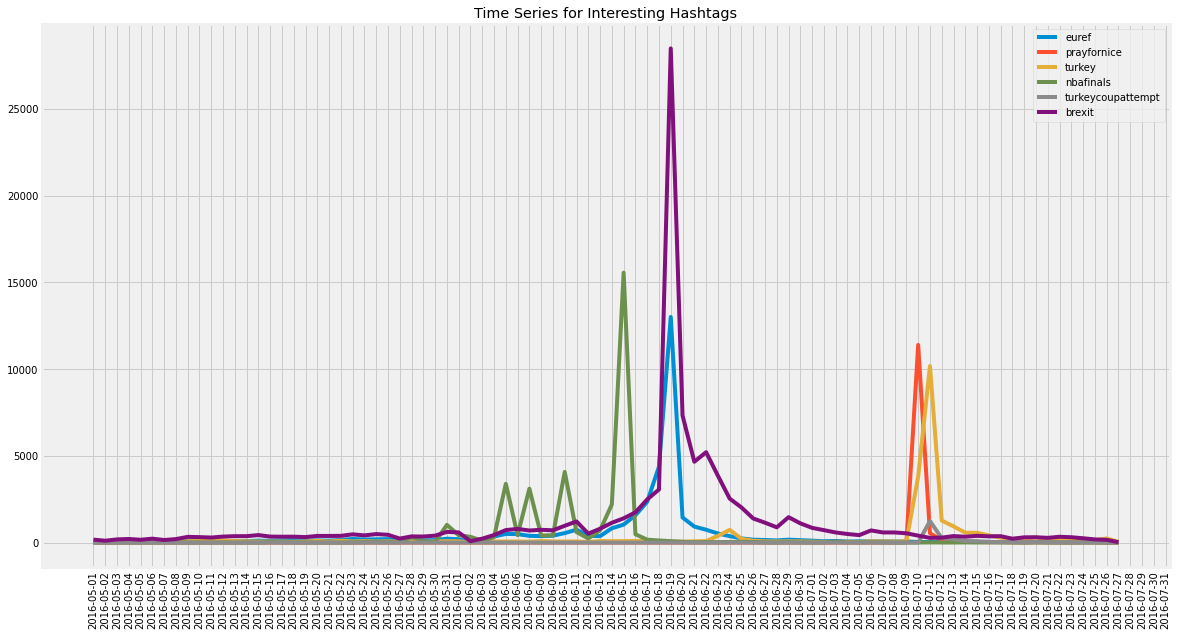

In [47]:
%%local
%matplotlib inline
import numpy as np
import pandas as pd
def to_array(ordered_dict):
    if 'size' not in ordered_dict.keys():
        return np.array(ordered_dict['values'])
    new_array = np.zeros((ordered_dict['size']))
    for i in range(len(ordered_dict['indices'])):
        index=ordered_dict['indices'][i]
        new_array[index]=ordered_dict['values'][i]
    return new_array
interesting_hashtags.numeric_features = interesting_hashtags.features.map(lambda x: to_array(x) )
plt.figure(figsize=(18,10))
plt.title('Time Series for Interesting Hashtags')
for i, hashtag in enumerate(interesting_hashtags.hashtag.values):
    plt.plot(interesting_hashtags.numeric_features[i])
dates=pd.date_range(start='05/01/2016', end='07/31/2016').date
plt.xticks(list(range(len(dates))),dates,rotation=90)
plt.legend(interesting_hashtags.hashtag.values)
plt.show()

Here we chose brexit, prayfornice, turkeycoupattempt, turkey, euref, and nbafinals as our hashtags. 

### II.h: TODO - Use KMeans to cluster hashtags based on the daily count timeseries (12 points / 50)

Use the DataFrame you created above to cluster the hashtag timeseries. Train the model and calculate the cluster membership for all hashtags. 

Show the cluster that includes "brexit" - does it make sense?

Again, be creative and see if you can get the clustering to give you meaningful hashtag groupings. Make sure you document your process and code and make your final notebook easy to understand even if the result is not optimal or complete. 

__Hint:__ Additional data cleaning or filtering might be necessary to get useful results from the model. 

As a first step we only removed hashtags that has total count less than 100 and greater than 200 000, but since K-means does not work well with large dimesions, we do not expect good results.

So, we train our model for different k values(2-16) to calculate cost and silhoutte score.

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import random


silhouettes = []
cost =[]


for k in range(2,16):
    kmeans = KMeans().setK(k).setSeed(random.randint(1,999999))
    model = kmeans.fit(vector_matrix)
    predictions = model.transform(vector_matrix)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))
    cost += [model.computeCost(vector_matrix)]
    silhouettes += [silhouette]


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [66]:

silhouettesDf = spark.createDataFrame(zip(range(2,16),silhouettes))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
silhouettesDf = spark.createDataFrame(zip(range(2,16),silhouettes))
costDf = spark.createDataFrame(zip(range(2,16),cost))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
%%spark -o silhouettesDf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [69]:
%%spark -o costDf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [73]:
%%local
costDf._2.values

array([2.41446997e+10, 2.34617755e+10, 2.15881643e+10, 2.09883056e+10,
       2.09703351e+10, 1.99456709e+10, 1.97499456e+10, 1.83441837e+10,
       1.86040581e+10, 1.78352539e+10, 1.75740118e+10, 1.58346612e+10,
       1.67132511e+10, 1.56847807e+10])

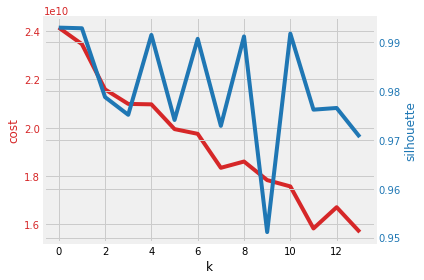

In [74]:
%%local
%matplotlib inline
cost = costDf._2.values
silhouettes = silhouettesDf._2.values

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('cost', color=color)
ax1.plot(cost, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('silhouette', color=color)  
ax2.plot(silhouettes, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

From the graph you can observe that 10 is a good cluster size since it has a high silhouette score and low cost.

In [75]:
from pyspark.ml.clustering import KMeans
import random


kmeans = KMeans(featuresCol='features').setK(10).setSeed(random.randint(1,1000))
model = kmeans.fit(normalized_vector_matrix)
predictions = model.transform(normalized_vector_matrix)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [76]:
predictions.select("hashtag","prediction").filter("hashtag == 'brexit'").select("prediction").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+
|prediction|
+----------+
|         6|
+----------+

Now we can see that brexit assigned to the cluster 6,lets see the size of cluster 6

In [77]:
predictions.select("hashtag","prediction").filter("prediction == '6'").select("hashtag").count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

60

Ok, 60 is way too much for a cluster but in any case let's see the hashtags in the cluster 6

In [79]:
predictions.select("hashtag","prediction").filter("prediction == '6'").select("hashtag").show(60)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+
|            hashtag|
+-------------------+
|                art|
|            jewelry|
|             travel|
|           etsymntt|
|aldub1stanniversary|
|           bigolive|
|            android|
|              euref|
|             hiring|
|               mufc|
|        gameinsight|
|               mgwv|
|              trump|
|         soundcloud|
|                 rt|
|               news|
|           giveaway|
|               love|
|               porn|
|              porno|
|     teamfollowback|
|                 np|
|                job|
|               etsy|
|        photography|
|          marketing|
|               free|
|            retweet|
|               nsfw|
|      gameofthrones|
|               maga|
|       mplusrewards|
|              music|
|                xxx|
|          periscope|
|          trump2016|
|               tcot|
|             trecru|
|               got7|
|        competition|
|                win|
|        followtrick|
|         

Now we can try to decrease number of features(to 30) by using PCA.

In [11]:
from pyspark.ml.feature import PCA
pca = PCA(k=30, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(normalized_vector_matrix)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
print("Principal components",model.explainedVariance)
print("")
print("Total explained variance:",sum(model.explainedVariance))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

('Principal components', DenseVector([0.2354, 0.0731, 0.0589, 0.0488, 0.0466, 0.0359, 0.0328, 0.0267, 0.0238, 0.0215, 0.0198, 0.0183, 0.0173, 0.0162, 0.0153, 0.0146, 0.0134, 0.0113, 0.0112, 0.0107, 0.0103, 0.01, 0.0093, 0.009, 0.0084, 0.0083, 0.0078, 0.0076, 0.0071, 0.0069]))

('Total explained variance:', 0.8359673462441878)

By using 30 features we can still preserve 83% of the variance, so let's try KMeans with these new principal components.

In [12]:
pca_data = model.transform(vector_matrix)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import random


kmeans = KMeans(featuresCol='pcaFeatures').setK(10).setSeed(random.randint(1,1000))
model = kmeans.fit(pca_data)
predictions = model.transform(pca_data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
predictions.select("hashtag","prediction").filter("hashtag == 'brexit'").select("prediction").show()

An error was encountered:
Invalid status code '404' from http://iccluster044.iccluster.epfl.ch:8998/sessions/3638 with error payload: "Session '3638' not found."


In [ ]:
predictions.select("hashtag","prediction").filter("prediction == '3'").select("hashtag").count()

In [ ]:
predictions.select("hashtag","prediction").filter("prediction == '12'").select("hashtag").show()


Since we could not achieve nice clusters by using daily counts, we can try to reduce feature size(curse of dimensionality) by using weekly counts, so that we will have only 13 features, and we can reduce the noise in the data.

In [19]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import random

hashtag_total_count = english_df.groupBy('hashtag').count()
#valid_ht = hashtag_total_count.filter('count > 100').select('hashtag').distinct().collect()
valid_ht = [row.hashtag for row in hashtag_total_count.filter('count > 100').select('hashtag').distinct().collect()]
hashtag_total_count.filter('count > 100').select('hashtag')
filteredDf = day_counts.filter(day_counts.hashtag.isin(valid_ht))
weeklycount = filteredDf.groupBy("hashtag","week").agg(functions.sum("count").alias("wcount"))
pivotDf = weeklycount.select('hashtag', 'week',"wcount").groupBy('hashtag').pivot('week').agg(functions.first("wcount"))
pivotDf = pivotDf.na.fill(0)
ignore = ['hashtag',"total"]
assembler = VectorAssembler(
    inputCols=[x for x in pivotDf.columns if x not in ignore],outputCol='features')

vector_matrix = assembler.transform(pivotDf)



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
seedRand

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

432462

In [24]:
silhouettes = []
cost =[]
for k in range(8,24,2):
    kmeans = KMeans().setK(k).setSeed(seedRand)
    model = kmeans.fit(vector_matrix)
    predictions = model.transform(vector_matrix)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))
    cost += [model.computeCost(vector_matrix)]
    silhouettes += [silhouette]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Silhouette with squared euclidean distance = 0.97675962549
Silhouette with squared euclidean distance = 0.979176141477
Silhouette with squared euclidean distance = 0.949281670001
Silhouette with squared euclidean distance = 0.943010908051
Silhouette with squared euclidean distance = 0.953473461936
Silhouette with squared euclidean distance = 0.952076176338
Silhouette with squared euclidean distance = 0.841114020703
Silhouette with squared euclidean distance = 0.952420689792

In [36]:
silhouettesDf = spark.createDataFrame(zip(range(2,16),silhouettes))
costDf = spark.createDataFrame(zip(range(2,16),cost))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
%%spark -o silhouettesDf


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
%%spark -o costDf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now let's do the elbow method and silhoette score analysis for the new data

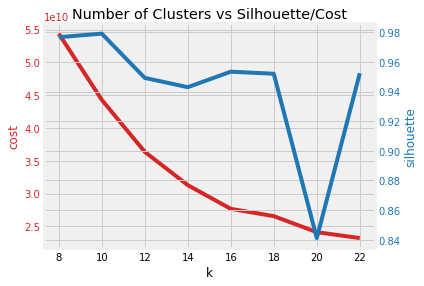

In [33]:
%%local
%matplotlib inline
cost = costDf._2.values
silhouettes = silhouettesDf._2.values

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('cost', color=color)
ax1.plot(range(8,24,2),cost, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('silhouette', color=color)  
ax2.plot(range(8,24,2),silhouettes, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Number of Clusters vs Silhouette/Cost')


plt.show()

From the above table we can say number of clusters as 15 is sufficient(form elbow method/ with good silhouette score).

In [34]:
k = 15
#seedRand = random.randint(1,999999)
seedRand = 432462
kmeans = KMeans().setK(k).setSeed(seedRand)
model = kmeans.fit(vector_matrix)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:

predictions = model.transform(vector_matrix)
predictions.select("hashtag","prediction").filter("hashtag == 'brexit'").select("prediction").show()
predictions.groupBy("prediction").count().sort("prediction").show(k)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+
|prediction|
+----------+
|         6|
+----------+

+----------+-----+
|prediction|count|
+----------+-----+
|         0|34377|
|         1|    1|
|         2|  747|
|         3|    1|
|         4|   20|
|         5|   14|
|         6|    2|
|         7|    2|
|         8|    3|
|         9|   53|
|        10|    1|
|        11|    1|
|        12|   61|
|        13|    2|
|        14|    1|
+----------+-----+

Above you can see the distribution of sizes of clusters, and Brexit is assigned cluster "6" which has a size of 2. Now let's check what is the other hashtag.

In [22]:
predictions.select("hashtag","prediction").filter("prediction == '6'").select("hashtag").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+
|hashtag|
+-------+
|  euref|
| brexit|
+-------+

Ok now we have euref and brexit, which are highly related. You can also check our graph in 2.g and it can be observed that these twho hastags made their peak almost simultaneously. 